In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
import seaborn as sns

# Pretty display for notebooks
%matplotlib inline

# bernoulli conf int. est.
from statsmodels.stats.proportion import proportion_confint, multinomial_proportions_confint
from scipy import stats

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))



The scikit-learn version is 0.20.3.


# 1. Data Gathering phase

This project makes use of the dataset: “The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on 2019-04-01.


The dataset is also available on Kaggle [1]


The dataset is unzipped in the current directory and comprises of several csv files. At this step we focus on the orders data.

[1] [Kaggle Instacart competition](https://www.kaggle.com/c/instacart-market-basket-analysis)



In [127]:
orders=pd.read_csv('orders.csv')

# 2. Data Assessment phase

The next step is to analyze the structure of the data and to look for missing values in columns and in rows.

In [128]:
print(orders.shape)

display(orders.head())

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [129]:
print('number orders records: ', (orders.shape[0]) )
print('number of unique orders: ', np.unique(orders.order_id).shape[0] )
print('number of unique users: ', np.unique(orders.user_id).shape[0] )



number orders records:  3421083
number of unique orders:  3421083
number of unique users:  206209


## 2.1 Missing values

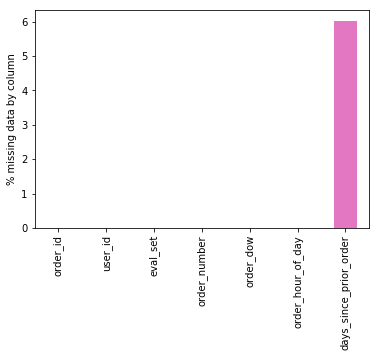

In [130]:

null_values_count=orders.isnull().sum()
perc_missing_values=100.*null_values_count/orders.shape[0]
perc_missing_values.plot(kind='bar')

plt.ylabel('% missing data by column');


We should not worry that sometimes "days_since_prior_order" is nan. Given that the data is gathered electronically from the online shopping website, it simply means that there was no prior order for that customer, i.e. a customer is issuing its first order. This should not be confused with "days_since_prior_order==0", i.e. two or more orders from the same customer in the same day.

In the next cell, we will look for missing values in rows.

number_of_rows: 3421083


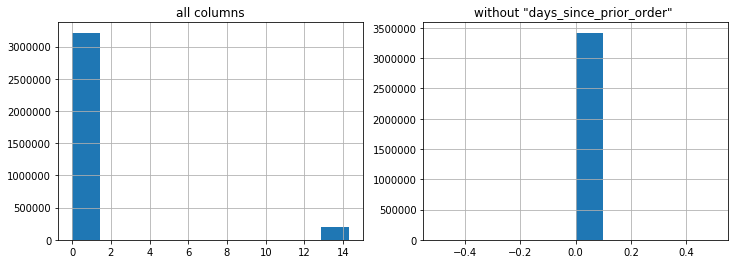

In [131]:
number_of_columns=orders.shape[1]
print("number_of_rows:",orders.shape[0])

plt.figure(figsize=(12,4))
plt.subplot(121)
null_values_rows=orders.isnull().sum(axis=1)
perc_missing_values_rows=100.*null_values_rows/number_of_columns
perc_missing_values_rows.hist()
plt.title('all columns')

plt.subplot(122)
null_values_rows=orders[['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day']].isnull().sum(axis=1)
perc_missing_values_rows=100.*null_values_rows/number_of_columns
perc_missing_values_rows.hist();
plt.title('without "days_since_prior_order" ');


## 2.1 Conclusions of the assessment phase

The missing values are only due to "days_since_prior_order" are not a concern but they should be treated appropriately (e.g. creating an ad-hoc variable).

# 3. Data Cleaning phase

As mentioned above, the correct way of dealing with missing values in this case is to interpret them correctly.
There is no need to impute values.

In [132]:
orders['first_order']=0
orders.loc[orders.days_since_prior_order.isnull(),'first_order']=1

In [133]:
orders.loc[orders.days_since_prior_order.isnull(),'days_since_prior_order']=0

In [134]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,first_order
0,2539329,1,prior,1,2,8,0.0,1
1,2398795,1,prior,2,3,7,15.0,0
2,473747,1,prior,3,3,12,21.0,0
3,2254736,1,prior,4,4,7,29.0,0
4,431534,1,prior,5,4,15,28.0,0


# 4. Data Analysis phase

# 4.1 Business Objectives
The goal of this project is to identify different cathegories of users and investigate if they exhibit different behavior, such as different buying patterns. 
Specifically we are interested in users that placed a large number of orders (frequent users) 

The business questions that we want to answer are:
1. Do frequent users  order in different days than infrequent users?
2. Do frequent frequent users order at different hours in the day than infrequent users?
3. How often do frequent users place orders compared to infrequent users?




## 4.2 Model and Visualize phase

### 4.2.1 Identify the frequent users

In [135]:
orders_by_users=orders.groupby(by='user_id')

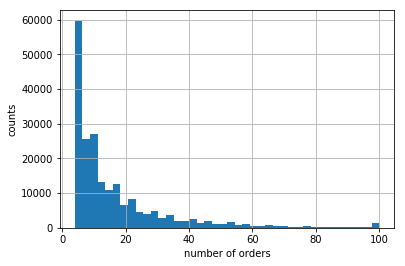

In [136]:
orders_by_users=orders['user_id'].value_counts()
orders_by_users.hist(bins=40);
plt.xlabel('number of orders');
plt.ylabel('counts');


In [137]:
order_low_threshold=10
order_high_threshold=40

frequent_users=orders_by_users.loc[orders_by_users > order_high_threshold]
infrequent_users=orders_by_users.loc[orders_by_users < order_low_threshold]



In [138]:
orders['user_type']='mid'
orders.loc[orders.user_id.isin(list(frequent_users.index)),'user_type']='high'
orders.loc[orders.user_id.isin(list(infrequent_users.index)),'user_type']='low'



In [139]:
np.unique(orders['user_type'].values)

array(['high', 'low', 'mid'], dtype=object)

In [140]:
user_type_proportions=orders.groupby(by='user_type')['order_id'].agg('count')/orders.shape[0]
display(user_type_proportions)

user_type
high    0.315068
low     0.167533
mid     0.517399
Name: order_id, dtype: float64

This simple analysis shows that frequent users (labels "high" and "mid") represent > 80% of the orders and that therefore understanding their order patterns is very relevant. 

### 4.2.2 Descriptive Statistics

We have clustered the users according to the amount of purchases. Now we will use descriptive statistics to see if their order patterns differ. For example we would like to see if these groups spread their orders uniformly over the week or if they have specific tendencies.



In [141]:
orders.groupby(by='user_type')['order_dow'].agg([np.mean,np.std])

,mean,std
user_type,,
high,2.825555,1.990747
low,2.742819,2.080294
mid,2.756992,2.068929


In [142]:
dow_by_user_type= orders.groupby(by='user_type')['order_dow'].value_counts().unstack().T

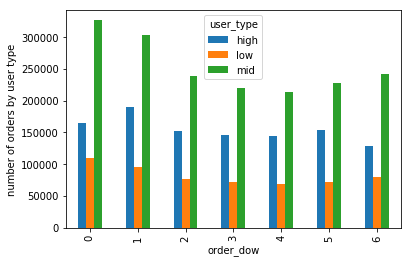

In [143]:
dow_by_user_type.plot(kind="bar");
plt.ylabel('number of orders by user type');

### 4.2.3 Multinomial Proportion CI

Is it possible to do something more? We can consider the rows of the DataFrame order as experiments from multinomial variables and utilize the function [1] from statsmodels.
It is not completely straightforward if we can assume that the experiments are independent and identically distributed (as there are repeat users and previous experiences may have influence). However, the sample size is 3.4 million orders and in such cases it is typically permissible to make such assumptions.  


It should be noted that the implementation of multinomial_proportions_confint in [1] cannot be applied in parallel to a DataFrame with a multinomial experiment in each row but only to a single array corresponding to a multinomial experiment. This can be handled with a simple for loop. However, extending [1] to a dataframe is quite trivial. The following code can also be found in [2] and will be made available in pypi soon.
The vectorialized version of the code can be used for large dataframes with many different groups of multinomial experiments.


[1] [multinomial_proportions_confint from statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.multinomial_proportions_confint.html)

[2] [github.com/marco-bellini/df_multinomial](https://github.com/marco-bellini/df_multinomial)


In [144]:
def multinomial_proportions_confint_df(df_counts, alpha=0.05):
    ''' Confidence intervals for multinomial proportions stored in pandas dataframe
    adapted from https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.multinomial_proportions_confint.html

    Parameters
    ----------
    :param df_counts: pandas DataFrame
        each row of the dataframe is an experiment and contains the number of observations in each category.
    :param alpha: float in (0, 1), optional
        Significance level, defaults to 0.05.
    :param: return_mean True/False, optional, False is default
        Add the mean of observations to the return dataframe


    Returns
    -------
    :return: confint : pandas DataFrame
        Array of ([mean],lower, upper) confidence levels for each category, such that
        overall coverage is (approximately) `1-alpha`.


    Raises
    ------
    .. TypeError if df_counts is not a DataFrame
    .. ValueError if alpha is not within (0,1)
    .. ValueError if df_counts contains negative numbers

    Notes
    -----


    References
    ----------

    .. [1] Levin, Bruce, "A representation for multinomial cumulative
       distribution functions," The Annals of Statistics, Vol. 9, No. 5,
       1981, pp. 1123-1126.

    .. [2] Goodman, L.A., "On simultaneous confidence intervals for multinomial
           proportions," Technometrics, Vol. 7, No. 2, 1965, pp. 247-254.

    .. [3] Sison, Cristina P., and Joseph Glaz, "Simultaneous Confidence
           Intervals and Sample Size Determination for Multinomial
           Proportions," Journal of the American Statistical Association,
           Vol. 90, No. 429, 1995, pp. 366-369.

    .. [4] May, Warren L., and William D. Johnson, "A SAS® macro for
           constructing simultaneous confidence intervals  for multinomial
           proportions," Computer methods and programs in Biomedicine, Vol. 53,
           No. 3, 1997, pp. 153-162.

    '''



    # check for wrong inputs
    if not isinstance(df_counts, pd.DataFrame):
        raise TypeError('df_counts must be a pandas DataFrame')

    if alpha <= 0 or alpha >= 1:
        raise ValueError('alpha must be in (0, 1), bounds excluded')

    if (df_counts.values < 0).any():
        raise ValueError('counts must be >= 0')


    # n_experiments in every row
    n_experiments = df_counts.sum(axis=1)
    # k_values is the number of rows in the DataFrame
    k_values = df_counts.shape[1]

    # the number of experiments is widened to calculate proportions with a dividision between dataframes
    # row_counts has identical columns
    row_counts = pd.concat([ n_experiments] * k_values, axis=1)
    row_counts.columns = df_counts.columns

    proportions = df_counts.divide( row_counts )
    chi2 = stats.chi2.ppf(1 - alpha / k_values, 1)

    # all the following quantities are DataFrames of the same size as df_counts
    chi2_m = df_counts * 0 + chi2

    delta_numerator = np.sqrt(chi2 ** 2 + (4 * df_counts * chi2 * (1 - proportions)))
    n_m =  pd.concat([n_experiments] * k_values, axis=1)
    n_m.columns = df_counts.columns
    delta_divider = (2 * (chi2_m + n_m))

    # estimating the lower and upper bound of the confidence interval
    numerator= (2 * df_counts + chi2_m )
    num1=numerator - delta_numerator
    confidence_lower = num1.divide( delta_divider)

    num2 = numerator + delta_numerator
    confidence_upper = num2.divide( delta_divider)

    df_mean=proportions
    multi_columns={'mean':df_mean,'lb':confidence_lower,'ub':confidence_upper}
    region = pd.concat(multi_columns.values(), axis=1, keys=multi_columns.keys())

    return region


In [145]:
def multinomial_ci_plot_groups(input_df,groupby_col, feature, alpha=0.05, ax=None, label_prefix='', **kwargs):
    """
    takes as input the dataframe input_df and clusters it according to "groupby_col" (e.g.user_types) 
    then counts the occurrence of each categorical variable in column "feature" , this results in a dataframe counts having for rows the different groups according to groupby_col  
    and for columns the different values categorical variable.
    
    The confidence interval for each categorical variable are estimated and a series of errorbar plots (one for each group is generated).
    
    :param input_df: the dataframe with the multinomial experiments
    :param groupby_col: the column of input_df used to cluster the data. Each cluster will have a errorbar plot
    :param feature: the column of input_df containing the categorical variable
    :param alpha: the significance level of the confidence intervals for multinomial proportions.
    :param ax: optional axis handle, default None
    :param kwargs: for plt.errorbar
    :return:
    """
    
    counts = input_df.groupby(by=groupby_col)[feature].value_counts().unstack(level=1).fillna(0)  
    df = multinomial_proportions_confint_df(counts, alpha=alpha)


    groups = list(df.index)
    xm = df.columns.levels[1]

    for ind in groups:
        # prepare for errorbar plot
        ym = df.loc[ind]['mean']
        lb = df.loc[ind]['lb']
        ub = df.loc[ind]['ub']

        yerr_l = np.abs(lb - ym)
        yerr_u = np.abs(ub - ym)
        yerr = np.vstack((yerr_l, yerr_u))
        if isinstance(ind, (int, float, complex)):
            label = label_prefix+ '%g' % ind
        elif isinstance(ind, str):
            label = label_prefix+ind
        if ax is None:
            plt.errorbar(xm, ym, yerr=yerr, label=label, **kwargs);
        else:
            ax.errorbar(xm, ym, yerr=yerr, label=label, **kwargs);

    return ()


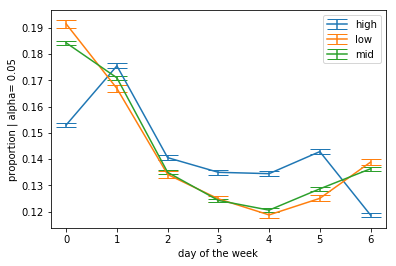

In [146]:
groupby_col='user_type'
feature="order_dow"
alpha=0.05
multinomial_ci_plot_groups(orders,groupby_col, feature, alpha=alpha,capsize=10);

plt.legend();
plt.xlabel('day of the week');
plt.ylabel('proportion | alpha= %g' % alpha);

This graph enable us to answer question 1: Do frequent users  order in different days than infrequent users?

Yes, it seems that heavy online shoppers ("high") are more prone to order on Mondays (day 1) rather than Saturday (day 6). 
Also "high" order shoppers order significantly less on Saturday and Sunday than the other two categories. They rather tend to order more during weekdays.

Conversely new and infrequent users tend to shop more on weekends. Maybe weekend promotions could be used to attract more new users or to encourage "mid" order users to order more frequently.




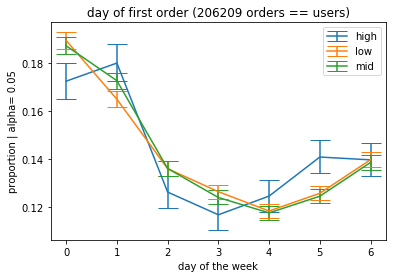

In [147]:
groupby_col='user_type'
feature="order_dow"
alpha=0.05
multinomial_ci_plot_groups(orders.loc[orders.first_order==True],groupby_col, feature, alpha=alpha,capsize=10);

plt.legend();
plt.xlabel('day of the week');
plt.ylabel('proportion | alpha= %g' % alpha);
plt.title('day of first order (%s orders == users)' % (orders.loc[orders.first_order==True].shape[0] ));

Interestingly it seems that the pattern holds also at the time of the first order, although the sample size is smaller and the confidence intervals are not very small anymore.

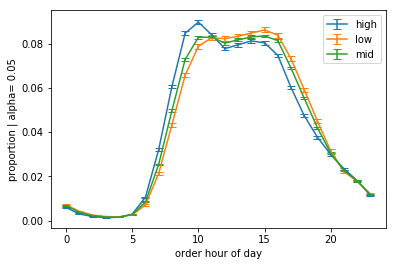

In [148]:
groupby_col='user_type'
feature="order_hour_of_day"
alpha=0.05
multinomial_ci_plot_groups(orders,groupby_col, feature, alpha=alpha,capsize=4);

plt.legend();
plt.xlabel(feature.replace('_',' '));
plt.ylabel('proportion | alpha= %g' % alpha);


The graph suggest that the answer to question 2 ( Do frequent frequent users order at different hours in the day than infrequent users? ) is that "high" users tend to order more in the morning and less in the afternoon compared to other users. Promotions at specific times could be used to increase the activity of "low" and "mid" users.

All users seem to do their online shopping during office hours. 



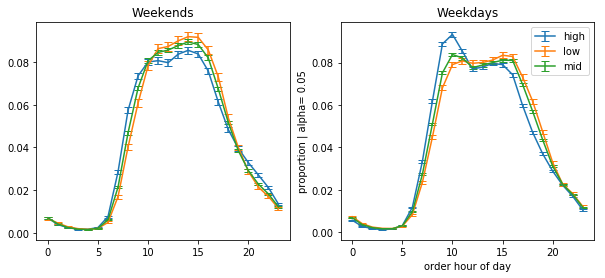

In [149]:
groupby_col='user_type'
feature="order_hour_of_day"
alpha=0.05

plt.figure(figsize=(10,4))

ax1=plt.subplot(121)
multinomial_ci_plot_groups(orders.loc[orders.order_dow.isin([0,6])],groupby_col, feature, alpha=alpha,ax=ax1,capsize=4);
plt.title('Weekends')

ax2=plt.subplot(122)
multinomial_ci_plot_groups(orders.loc[orders.order_dow.isin([1,2,3,4,5])],groupby_col, feature, alpha=alpha,ax=ax2,capsize=4);
plt.title('Weekdays')

plt.legend();
plt.xlabel(feature.replace('_',' '));
plt.ylabel('proportion | alpha= %g' % alpha);

Further analysis shows that "high" users tend to make orders earlier than others but only during weekdays and not so much during weekends.

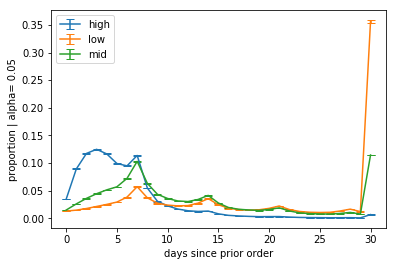

In [150]:
feature='days_since_prior_order'
multinomial_ci_plot_groups(orders.loc[orders.first_order==False],groupby_col, feature, alpha=alpha,capsize=4);

plt.legend();
plt.xlabel(feature.replace('_',' '));
plt.ylabel('proportion | alpha= %g' % alpha);

With this graph we can answer question 3: How often do frequent users place orders compared to infrequent users?
We exclude the zero values from the first orders.

Not surprisingly "high" users tend to make more orders within 0-5 of each order. All users seem to make every week or every 2 or 3 weeks.
Infrequent users also have a sizable percentage of orders at 30 (the maximum allowed value in the system)

## 4.3 Conclusion

This analysis, based on descriptive statistics has quickly shown that there are different groups of users:
* frequent users order more during the week and the morning. They also order more often (within 7 days of the previous order)
* infrequent users order more on evening and weekends and tend to order every week or so

We note that this analysis was possible because of the very large dataset (3.4 orders with 200k individual users). With a smaller number of orders and users it may have been more difficult to draw conclusions, as the confidence intervals would have been larger. Additionally the assumption of independence and identical distribution of the experiments has not been verified 

